In [49]:
#Installing the dependencies
!pip install wandb -qU
!pip install autogluon -q
!pip install keras-tuner --upgrade

In [50]:
#Loading the libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch import nn
import torch
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import f1_score,precision_score,recall_score,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import wandb
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Section 1: MLP Model Implementation & Experiment Tracking

In [51]:
#Loading data
data = load_iris()
X = data.data
y = data.target
classes = data.target_names

In [52]:
 # Explicit [0,1] range
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.125, random_state = 42)
print("Dimensions after train test Validation split")
print(X_train.shape,X_val.shape,X_test.shape)

Dimensions after train test Validation split
(105, 4) (15, 4) (30, 4)


In [53]:
#wandb Login
wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [54]:
#Neural Network Architecture
class NeuralNet(nn.Module):
  def __init__(self, input_dim=4,hidden_dim = 16,output_dim = 3):
    super(NeuralNet,self).__init__()
    self.fc1 = nn.Linear(input_dim,hidden_dim)
    self.f2 = nn.Linear(hidden_dim,output_dim)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self,X):
    out = self.fc1(X)
    out = self.relu(out)
    out = self.f2(out)
    out = self.softmax(out)
    return out

In [55]:
#Setting the Hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 500
# Initializing the model
model = NeuralNet()
# Optimizer
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
# Loss function
loss = nn.CrossEntropyLoss()

wandb.init(
    # set the wandb project where this run will be logged
    project="CS203 Lab 6",

    # track hyperparameters and run metadata
    config={
    "learning_rate": LEARNING_RATE,
    "architecture": "FC",
    "dataset": "IRIS",
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "hidden_dim": 16,
    "input_dim": 4,
    "output_dim": 3,
    }
)


train_losses = []
val_losses = []
#Training the model
for epoch in tqdm(range(EPOCHS)):
  cumm_loss = 0
  for i in range(0,len(X_train),BATCH_SIZE):
    X_batch = torch.tensor(X_train[i:i+BATCH_SIZE],dtype = torch.float32)
    y_batch = torch.tensor(y_train[i:i+BATCH_SIZE],dtype = torch.long)
    optimizer.zero_grad()
    y_pred = model(X_batch)
    train_loss = loss(y_pred,y_batch)
    cumm_loss += train_loss.item()
    train_loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    y_pred_val = model(torch.tensor(X_val,dtype= torch.float32))
    val_loss = loss(y_pred_val,torch.tensor(y_val,dtype = torch.long))
    y_pred = model(torch.tensor(X_train,dtype = torch.float32))
    train_acc = accuracy_score(y_train,np.argmax(y_pred.detach().numpy(),axis = 1))
    val_acc = accuracy_score(y_val,np.argmax(y_pred_val.detach().numpy(),axis = 1))
    train_losses.append(cumm_loss/len(X_train))
    val_losses.append(val_loss.item())
    wandb.log({"Train Loss": cumm_loss/len(X_train), "Validation loss": val_loss.item()})
    print(f"Epoch:{epoch}/{EPOCHS}, Train Loss:{cumm_loss/len(X_train)}, Val Loss:{val_loss.item()}, Train Acc: {train_acc}, Val Acc: {val_acc}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch:0/500, Train Loss:0.042357898893810454, Val Loss:1.0969170331954956, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:1/500, Train Loss:0.04228094986506871, Val Loss:1.0957691669464111, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:2/500, Train Loss:0.04220690046037946, Val Loss:1.0946274995803833, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:3/500, Train Loss:0.0421341305687314, Val Loss:1.0935152769088745, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:4/500, Train Loss:0.0420623813356672, Val Loss:1.0924570560455322, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:5/500, Train Loss:0.04199120771317255, Val Loss:1.0914705991744995, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:6/500, Train Loss:0.041920856067112516, Val Loss:1.0905269384384155, Train Acc: 0.3333333333333333, Val Acc: 0.26666666666666666
Epoch:7/500, Train Loss:0.04185071899777367, Val Loss:1.089630

**********
Test data Metrics
Accuracy:  0.9666666666666667
Precision:  0.9722222222222222
Recall:  0.9629629629629629
F1 Score: 0.9658994032395567
Confusion Matrix:
[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]


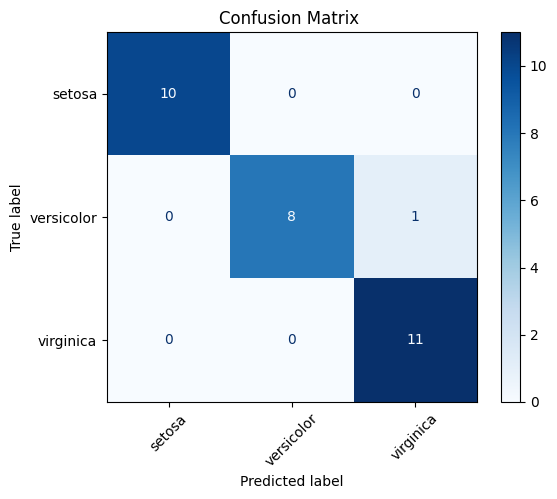

**********


In [56]:
def get_metrics(y_true,y_pred):
  accuracy = accuracy_score(y_true,y_pred)
  f1score = f1_score(y_true,y_pred,average='macro')
  precision = precision_score(y_true,y_pred,average='macro')
  recall = recall_score(y_true,y_pred,average='macro')
  print("Accuracy: ",accuracy)
  print("Precision: ",precision)
  print("Recall: ",recall)
  print("F1 Score:",f1score)

  cm = confusion_matrix(y_true,y_pred)
  print("Confusion Matrix:")
  print(cm)
  #Logging Metrics
  wandb.log({"Test Accuracy": accuracy,
             "Test Precision": precision,
             "Test Recall": recall,
             "F1 Score": f1score})
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true, preds=y_pred,
                        class_names=classes)})

  # Plot confusion matrix using sklearn's ConfusionMatrixDisplay
  labels = classes
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.xticks(rotation=45)
  plt.title("Confusion Matrix ")
  plt.show()

print("*"*10)
print("Test data Metrics")
y_pred_test = np.argmax(model(torch.tensor(X_test,dtype = torch.float32)).detach().numpy(),axis = 1)
get_metrics(y_test,y_pred_test)
print("*"*10)

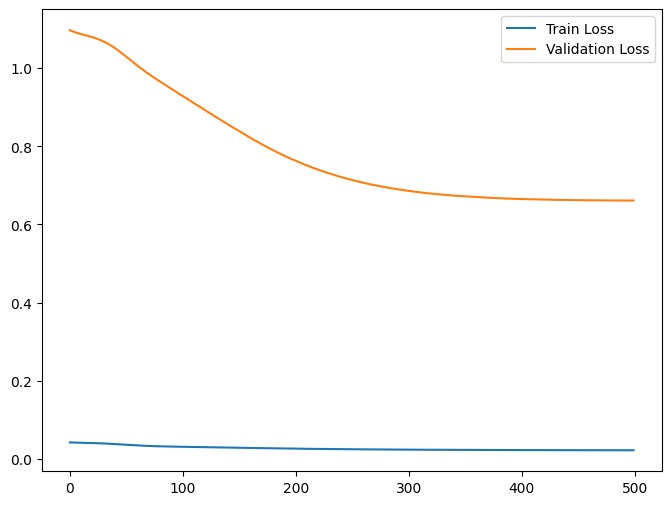

In [57]:
def plot_losses(train_losses,val_losses):
  plt.figure(figsize=(8,6))
  plt.plot(train_losses,label = "Train Loss")
  plt.plot(val_losses,label = "Validation Loss")
  plt.legend()
  plt.show()
plot_losses(train_losses,val_losses)

# Section 2: Hyperparameters

Task 1: Hyperparameter Optimization

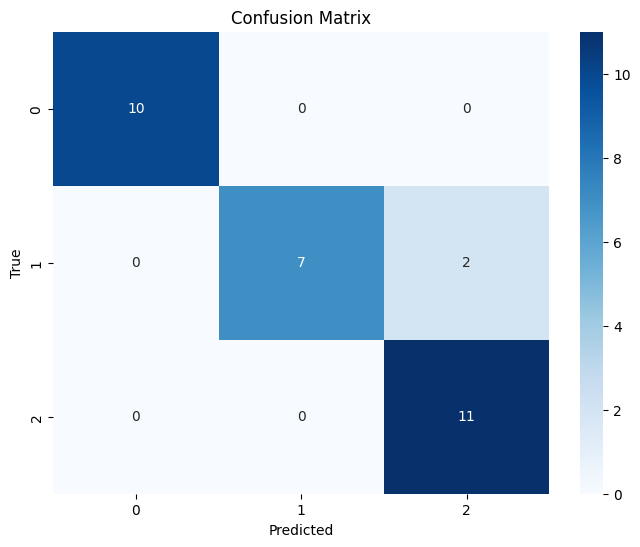

Sample 3:
Input: tensor([ 2.2497, -1.0528,  1.7858,  1.4488])
Prediction: 2
Truth: 2

Sample 29:
Input: tensor([-1.2642, -0.1320, -1.3402, -1.1838])
Prediction: 0
Truth: 0

Sample 14:
Input: tensor([-1.1430,  0.0982, -1.2834, -1.4471])
Prediction: 0
Truth: 0

Sample 11:
Input: tensor([0.7957, 0.3284, 0.7628, 1.0539])
Prediction: 2
Truth: 2

Sample 27:
Input: tensor([ 1.0380, -1.2830,  1.1606,  0.7907])
Prediction: 2
Truth: 2

Batch Size: 2, Learning Rate: 0.001, Epochs: 1
Accuracy: 0.4667, F1 Score: 0.4106

Batch Size: 2, Learning Rate: 0.001, Epochs: 3
Accuracy: 0.9333, F1 Score: 0.9319

Batch Size: 2, Learning Rate: 0.001, Epochs: 5
Accuracy: 0.7000, F1 Score: 0.5935

Batch Size: 2, Learning Rate: 1e-05, Epochs: 1
Accuracy: 0.2667, F1 Score: 0.1714

Batch Size: 2, Learning Rate: 1e-05, Epochs: 3
Accuracy: 0.3333, F1 Score: 0.2066

Batch Size: 2, Learning Rate: 1e-05, Epochs: 5
Accuracy: 0.6333, F1 Score: 0.5195

Batch Size: 4, Learning Rate: 0.001, Epochs: 1
Accuracy: 0.4000, F1 Scor

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming NeuralNet and prepare_data functions are defined as in the previous section

def train_and_evaluate(model, train_data, test_data, batch_size, learning_rate, epochs):
    train_loader = DataLoader(TensorDataset(*train_data), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(*test_data), batch_size=len(test_data[0]))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        X_test, y_test = next(iter(test_loader))
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

    accuracy = accuracy_score(y_test, predicted)
    f1 = f1_score(y_test, predicted, average='weighted')
    cm = confusion_matrix(y_test, predicted)

    return model, accuracy, f1, cm, X_test, y_test, predicted

# Prepare data
train_data, val_data, test_data = prepare_data()

# Hyperparameters
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

results = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            model = NeuralNet()
            model, accuracy, f1, cm, X_test, y_test, predicted = train_and_evaluate(
                model, train_data, test_data, batch_size, learning_rate, epochs)
            results.append({
                'batch_size': batch_size,
                'learning_rate': learning_rate,
                'epochs': epochs,
                'accuracy': accuracy,
                'f1_score': f1,
                'confusion_matrix': cm,
                'X_test': X_test,
                'y_test': y_test,
                'predicted': predicted
            })

# Plot confusion matrix for the best model
best_model = max(results, key=lambda x: x['accuracy'])
plt.figure(figsize=(8, 6))
sns.heatmap(best_model['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Show inputs, predictions, and truth values for five samples
sample_indices = np.random.choice(len(best_model['X_test']), 5, replace=False)
for idx in sample_indices:
    print(f"Sample {idx + 1}:")
    print(f"Input: {best_model['X_test'][idx]}")
    print(f"Prediction: {best_model['predicted'][idx]}")
    print(f"Truth: {best_model['y_test'][idx]}")
    print()

# Print results
for result in results:
    print(f"Batch Size: {result['batch_size']}, Learning Rate: {result['learning_rate']}, Epochs: {result['epochs']}")
    print(f"Accuracy: {result['accuracy']:.4f}, F1 Score: {result['f1_score']:.4f}")
    print()



Task 2: Automated Hyperparameter Search

Epoch 1/1
Train Loss: 1.0977, Val Loss: 1.0752
Train F1: 0.2563, Val F1: 0.3319
Train Confusion Matrix:
[[ 1  0 36]
 [ 7  5 21]
 [ 6  0 29]]
Val Confusion Matrix:
[[1 0 2]
 [1 1 6]
 [0 0 4]]
--------------------
Epoch 1/3
Train Loss: 1.0516, Val Loss: 1.0429
Train F1: 0.6146, Val F1: 0.5489
Train Confusion Matrix:
[[32  5  0]
 [13  5 15]
 [ 1  0 34]]
Val Confusion Matrix:
[[3 0 0]
 [1 2 5]
 [0 0 4]]
--------------------
Epoch 2/3
Train Loss: 0.9906, Val Loss: 1.0069
Train F1: 0.6037, Val F1: 0.4423
Train Confusion Matrix:
[[37  0  0]
 [ 9  2 22]
 [ 0  0 35]]
Val Confusion Matrix:
[[3 0 0]
 [1 1 6]
 [0 0 4]]
--------------------
Epoch 3/3
Train Loss: 0.9304, Val Loss: 0.9751
Train F1: 0.6479, Val F1: 0.4607
Train Confusion Matrix:
[[37  0  0]
 [ 4  4 25]
 [ 0  0 35]]
Val Confusion Matrix:
[[3 0 0]
 [0 1 7]
 [0 0 4]]
--------------------
Epoch 1/5
Train Loss: 1.1153, Val Loss: 1.0473
Train F1: 0.2034, Val F1: 0.4267
Train Confusion Matrix:
[[ 0  1 36]
 [ 0 33  0]
 [ 0 35  0]]
Val Confusi

No path specified. Models will be saved in: "AutogluonModels/ag-20250226_191119"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.66 GB / 12.67 GB (76.2%)
Disk Space Avail:   71.03 GB / 107.72 GB (65.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions a

Epoch 3/5
Train Loss: 1.0843, Val Loss: 1.0964
Train F1: 0.3619, Val F1: 0.0750
Train Confusion Matrix:
[[35  0  2]
 [26  7  0]
 [15 16  4]]
Val Confusion Matrix:
[[3 0 0]
 [7 0 1]
 [3 1 0]]
--------------------
Epoch 4/5
Train Loss: 1.0824, Val Loss: 1.0962
Train F1: 0.3619, Val F1: 0.0750
Train Confusion Matrix:
[[35  0  2]
 [26  7  0]
 [15 16  4]]
Val Confusion Matrix:
[[3 0 0]
 [7 0 1]
 [3 1 0]]
--------------------
Epoch 5/5
Train Loss: 1.0805, Val Loss: 1.0960
Train F1: 0.3619, Val F1: 0.0750
Train Confusion Matrix:
[[35  0  2]
 [26  7  0]
 [15 16  4]]
Val Confusion Matrix:
[[3 0 0]
 [7 0 1]
 [3 1 0]]
--------------------


Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9889.64 MB
	Train Data (Original)  Memory Usage: 0.00 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 4 | ['feature_0', 'feature_1', 'feature_2', 'feature_3']
	0.1s = Fit runtime
	4 features in origin

+--------------------------------------------------------+
| Configuration for experiment     NeuralNetFastAI       |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 20                    |
+--------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20250226_191123/models/NeuralNetFastAI


2025-02-26 19:12:06,207	INFO timeout.py:54 -- Reached timeout of 41.53329923519721 seconds. Stopping all trials.
2025-02-26 19:12:06,237	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20250226_191123/models/NeuralNetFastAI' in 0.0140s.
2025-02-26 19:12:07,433	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 20 trial(s):
- 78786_00000: FileNotFoundError('Could not fetch metrics for 78786_00000: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20250226_191123/models/NeuralNetFastAI/78786_00000')
- 78786_00001: FileNotFoundError('Could not fetch metrics for 78786_00001: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20250226_191123/models/NeuralNetFastAI/78786_00001')
- 78786_00002: FileNotFoundError('Could not fetch metrics for 78786_00002: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20250226_191123/mo

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: LightGBMXT/T1 ...
	0.9333	 = Validation score   (accuracy)
	0.65s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	0.9333	 = Validation score   (accuracy)
	0.63s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	0.6667	 = Validation score   (accuracy)
	0.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	0.9333	 = Validation score   (accuracy)
	0.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	0.8667	 = Validation score   (accuracy)
	0.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	0.9333	 = Validation score   (accuracy)
	0.77s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	0.8667	 = Validation score   (accuracy)
	0.62s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT/T8 ...
	0.2	 = Validation score   (accuracy)
	0.6s	 = Training   

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: LightGBM/T1 ...
	0.9333	 = Validation score   (accuracy)
	0.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	0.9333	 = Validation score   (accuracy)
	0.81s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	0.8	 = Validation score   (accuracy)
	0.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	0.8667	 = Validation score   (accuracy)
	0.68s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	0.9333	 = Validation score   (accuracy)
	0.63s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	0.9333	 = Validation score   (accuracy)
	0.63s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T7 ...
	0.8667	 = Validation score   (accuracy)
	0.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM/T8 ...
	0.2	 = Validation score   (accuracy)
	0.61s	 = Training   runtime
	0.0s	 = Va

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: CatBoost/T1 ...
	0.9333	 = Validation score   (accuracy)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T2 ...
	0.9333	 = Validation score   (accuracy)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T3 ...
	0.9333	 = Validation score   (accuracy)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T4 ...
	0.9333	 = Validation score   (accuracy)
	0.17s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T5 ...
	0.9333	 = Validation score   (accuracy)
	0.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T6 ...
	0.9333	 = Validation score   (accuracy)
	0.24s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T7 ...
	0.9333	 = Validation score   (accuracy)
	0.17s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: CatBoost/T8 ...
	0.9333	 = Validation score   (accuracy)
	0.16s	 = Training   runtime
	0.0

  0%|          | 0/20 [00:00<?, ?it/s]

Fitted model: XGBoost/T1 ...
	0.8667	 = Validation score   (accuracy)
	0.12s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T2 ...
	0.9333	 = Validation score   (accuracy)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T3 ...
	0.9333	 = Validation score   (accuracy)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T4 ...
	0.9333	 = Validation score   (accuracy)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T5 ...
	0.9333	 = Validation score   (accuracy)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T6 ...
	0.9333	 = Validation score   (accuracy)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T7 ...
	0.8667	 = Validation score   (accuracy)
	0.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: XGBoost/T8 ...
	0.9333	 = Validation score   (accuracy)
	0.09s	 = Training   runtime
	0.0s	 = Vali

+--------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch        |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 20                    |
+--------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20250226_191123/models/NeuralNetTorch


2025-02-26 19:13:28,121	INFO timeout.py:54 -- Reached timeout of 41.53329923519721 seconds. Stopping all trials.
2025-02-26 19:13:28,181	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20250226_191123/models/NeuralNetTorch' in 0.0099s.
2025-02-26 19:13:31,375	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 20 trial(s):
- a9544_00000: FileNotFoundError('Could not fetch metrics for a9544_00000: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20250226_191123/models/NeuralNetTorch/a9544_00000')
- a9544_00001: FileNotFoundError('Could not fetch metrics for a9544_00001: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20250226_191123/models/NeuralNetTorch/a9544_00001')
- a9544_00002: FileNotFoundError('Could not fetch metrics for a9544_00002: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20250226_191123/model

	0.9333	 = Validation score   (accuracy)
	0.92s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 470.58s of remaining time.
	Ensemble Weights: {'NeuralNetFastAI/78786_00002': 1.0}
	1.0	 = Validation score   (accuracy)
	0.08s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 129.53s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 1299.1 rows/s (15 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/AutogluonModels/ag-20250226_191123")
No path specified. Models will be saved in: "AutogluonModels/ag-20250226_191333"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Av

Hyperparameter Optimization Comparison:
      Method  Best Accuracy  Best F1-Score
0     Manual       0.866667       0.866667
1       Grid       0.971429       0.971429
2     Random       1.000000       1.000000
3  Hyperband       0.971429       0.971429


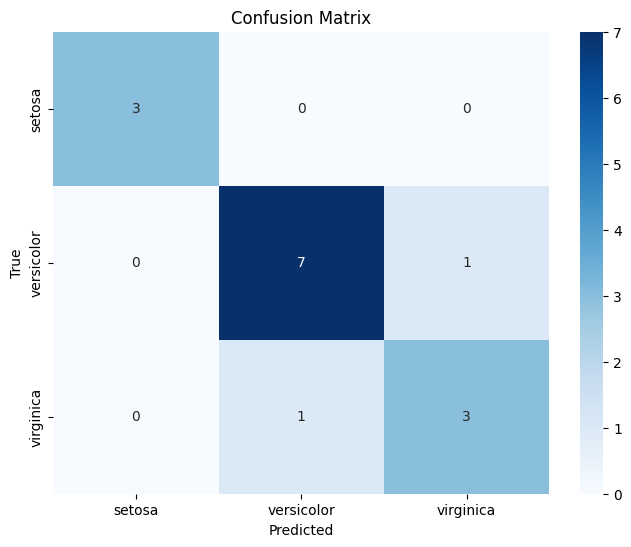

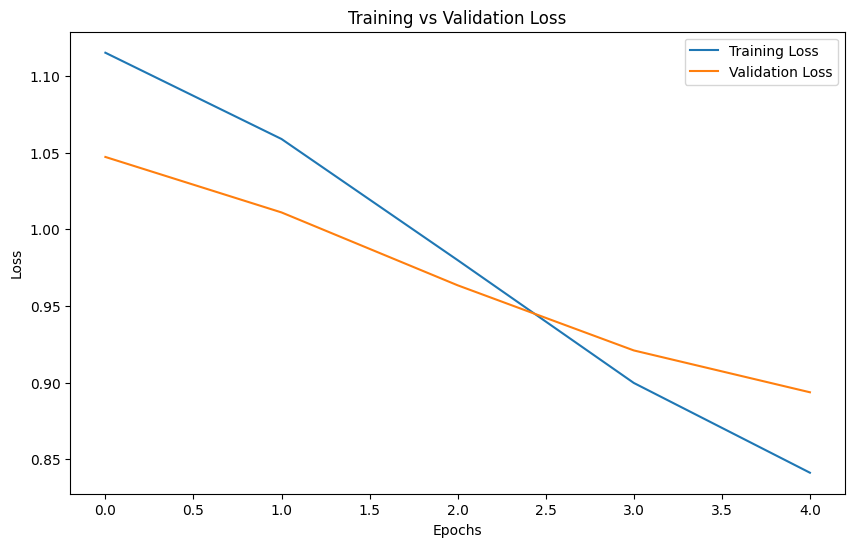

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor

class NeuralNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=3):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

def prepare_data():
    iris = load_iris()
    X, y = iris.data, iris.target
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

    X_train, y_train = torch.FloatTensor(X_train), torch.LongTensor(y_train)
    X_val, y_val = torch.FloatTensor(X_val), torch.LongTensor(y_val)
    X_test, y_test = torch.FloatTensor(X_test), torch.LongTensor(y_test)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def train_with_metrics(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.numpy())
            train_labels.extend(batch_y.numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.numpy())
                val_labels.extend(batch_y.numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        train_cm = confusion_matrix(train_labels, train_preds)
        val_cm = confusion_matrix(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")
        print("Train Confusion Matrix:")
        print(train_cm)
        print("Val Confusion Matrix:")
        print(val_cm)
        print("--------------------")

    return train_losses, val_losses

def manual_hp_tuning(model, train_data, val_data):
    results = []
    batch_sizes = [2, 4]
    learning_rates = [1e-3, 1e-5]
    epochs_list = [1, 3, 5]
    criterion = nn.CrossEntropyLoss()

    for bs in batch_sizes:
        train_loader = DataLoader(TensorDataset(*train_data), batch_size=bs, shuffle=True)
        val_loader = DataLoader(TensorDataset(*val_data), batch_size=len(val_data[0]))

        for lr in learning_rates:
            for epochs in epochs_list:
                model_instance = model()
                optimizer = optim.Adam(model_instance.parameters(), lr=lr)

                train_losses, val_losses = train_with_metrics(model_instance, train_loader, val_loader, criterion, optimizer, epochs)

                model_instance.eval()
                with torch.no_grad():
                    val_X, val_y = next(iter(val_loader))
                    val_outputs = model_instance(val_X)
                    _, predicted = torch.max(val_outputs.data, 1)
                    accuracy = accuracy_score(val_y, predicted)
                    f1 = f1_score(val_y, predicted, average='weighted')
                    cm = confusion_matrix(val_y, predicted)

                results.append({
                    'batch_size': bs,
                    'learning_rate': lr,
                    'epochs': epochs,
                    'accuracy': accuracy,
                    'f1_score': f1,
                    'confusion_matrix': cm,
                    'train_losses': train_losses,
                    'val_losses': val_losses
                })

    return results

def autogluon_hp_search(train_data, val_data, search_strategy):
    train_df = pd.DataFrame(np.column_stack((train_data[0], train_data[1])))
    val_df = pd.DataFrame(np.column_stack((val_data[0], val_data[1])))

    feature_cols = [f'feature_{i}' for i in range(train_data[0].shape[1])]
    train_df.columns = feature_cols + ['label']
    val_df.columns = feature_cols + ['label']

    predictor = TabularPredictor(label='label', eval_metric='accuracy').fit(
        train_data=train_df,
        tuning_data=val_df,
        time_limit=600,
        hyperparameter_tune_kwargs={
            'scheduler': 'local',
            'searcher': search_strategy,
            'num_trials': 20
        }
    )

    return predictor.leaderboard()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_loss_curves(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

def create_comparison_table(manual_results, grid_results, random_results, hyperband_results):
    comparison_data = []

    manual_best = max(manual_results, key=lambda x: x['accuracy'])
    comparison_data.append({
        'Method': 'Manual',
        'Best Accuracy': manual_best['accuracy'],
        'Best F1-Score': manual_best['f1_score']
    })

    for method, results in [('Grid', grid_results), ('Random', random_results), ('Hyperband', hyperband_results)]:
        best_model = results.iloc[0]
        comparison_data.append({
            'Method': method,
            'Best Accuracy': best_model['score_val'],
            'Best F1-Score': best_model['f1_score'] if 'f1_score' in best_model else best_model['score_val']
        })

    return pd.DataFrame(comparison_data)

if __name__ == "__main__":
    train_data, val_data, test_data = prepare_data()

    manual_results = manual_hp_tuning(NeuralNet, train_data, val_data)

    grid_results = autogluon_hp_search(train_data, val_data, 'grid')
    random_results = autogluon_hp_search(train_data, val_data, 'random')
    hyperband_results = autogluon_hp_search(train_data, val_data, 'hyperband')

    comparison_table = create_comparison_table(manual_results, grid_results, random_results, hyperband_results)
    print("Hyperparameter Optimization Comparison:")
    print(comparison_table)

    best_manual = max(manual_results, key=lambda x: x['accuracy'])
    plot_confusion_matrix(best_manual['confusion_matrix'], ['setosa', 'versicolor', 'virginica'])
    plot_loss_curves(best_manual['train_losses'], best_manual['val_losses'])
